In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import requests
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

## Read Station File

In [30]:
stations = pd.read_csv("/Users/avaisman/tmp/DataMisc/ScheldeData/StationsSchelde.csv")
stations.head()

,number,name,series,long,lat,localx,localy
0,29057,knt03a-SF-1066,44714010,4.742364,51.188737,176119.999688,208816.000594
1,29131,zes28a-SF-1066,45537010,4.330132,51.143320,147297.000000,203698.000000
2,255746,rup02e-SF-1066,120815010,4.366273,51.082338,149825.999727,196912.999941
3,29221,zes24a-SF-1066,46479010,4.326774,51.175399,147063.999693,207267.000352
4,268195,zes09x-SF-1066,110799010,4.285865,51.296685,144218.000000,220763.000000


## Read ec_schelde_all.csv file.
Contains the timeseries for all the stations from 2022/04/01 to 2022/04/10

In [31]:
big_df = pd.read_csv("/Users/avaisman/tmp/DataMisc/ScheldeData/ec_schelde_all.csv")
#Timestaps are strings, we change them to Timestaps and store them in 'ts' columns
big_df['ts']=pd.to_datetime(big_df['Timestamp'],errors='coerce')
big_df.head()

,Unnamed: 0,Timestamp,Value,Station,ts
0,0,2022-04-01 00:00:00+00:00,1412.81,29131,2022-04-01 00:00:00+00:00
1,1,2022-04-01 00:10:00+00:00,1434.60,29131,2022-04-01 00:10:00+00:00
2,2,2022-04-01 00:20:00+00:00,1512.09,29131,2022-04-01 00:20:00+00:00
3,3,2022-04-01 00:30:00+00:00,1535.31,29131,2022-04-01 00:30:00+00:00
4,4,2022-04-01 00:40:00+00:00,1557.16,29131,2022-04-01 00:40:00+00:00


## Show the Value column statistics
Global statistics

In [32]:
big_df['Value'].describe()

count    23040.000000
mean      7546.451115
std       6094.660816
min          0.000000
25%       1241.997500
50%       6687.500000
75%      13398.630000
max      20927.820000
Name: Value, dtype: float64

In [33]:
from matplotlib.ticker import StrMethodFormatter


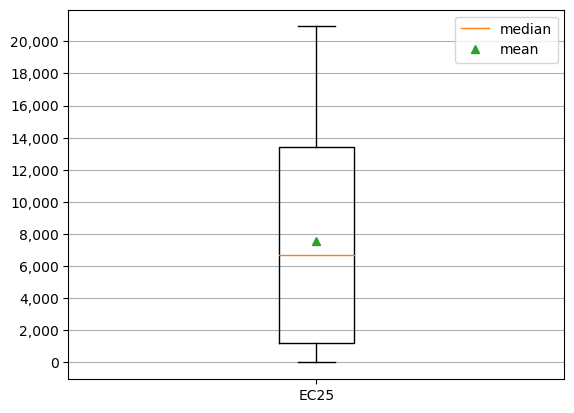

In [34]:
bp=plt.boxplot(big_df['Value'], showmeans=True)
plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'])
plt.xticks([1],["EC25"])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) #Format y axis
plt.yticks(range(int(big_df['Value'].min()),int(big_df['Value'].max())+1,2000))
plt.grid(axis='y')
plt.savefig('SchBoxplotGlobal.png',dpi=350, bbox_inches='tight')
plt.show()

In [35]:
#Stations numbers present in big_df
st_numbers = big_df['Station'].unique()
st_numbers

array([ 29131,  29221,  29315,  29333,  29472,  29666,  29732, 255746,
       268195])

In [36]:
stations=stations.reset_index()

#Temperature

In [37]:
temp_df = pd.read_csv("/Users/avaisman/tmp/DataMisc/ScheldeData/stw_schelde_all.csv")
#Timestaps are strings, we change them to Timestaps and store them in 'ts' columns
temp_df['ts']=pd.to_datetime(temp_df['Timestamp'],errors='coerce')
temp_df.head()

,Unnamed: 0,Timestamp,Value,Station,ts
0,0,2022-04-01 00:00:00+00:00,11.0,29131,2022-04-01 00:00:00+00:00
1,1,2022-04-01 00:10:00+00:00,11.0,29131,2022-04-01 00:10:00+00:00
2,2,2022-04-01 00:20:00+00:00,10.9,29131,2022-04-01 00:20:00+00:00
3,3,2022-04-01 00:30:00+00:00,10.9,29131,2022-04-01 00:30:00+00:00
4,4,2022-04-01 00:40:00+00:00,10.9,29131,2022-04-01 00:40:00+00:00


#IMPORTANT
run the following cells before plots

Initializing Variables

In [38]:
station_names=list(stations['name'])
station_names.sort(reverse=True)
station_names=station_names[:-1]
station_names=[station_names[-1]] + station_names[:-1]
#swap O and B
aux = station_names[6]
station_names[6]=station_names[7]
station_names[7]=aux

station_names

['rup02e-SF-1066',
 'zes39c-SF-1066',
 'zes28a-SF-1066',
 'zes24a-SF-1066',
 'zes19a-SF-B-1066',
 'zes09x-SF-1066',
 'zes07g-SF-B-1066',
 'zes07g-SF-O-1066',
 'zes01a-SF-1066']

In [39]:
big_df=big_df.reset_index()
big_df = big_df.set_index('Station')
stations = stations.reset_index()
stations=stations.set_index('name')
st = stations.loc[station_names]['number']
temp_df=temp_df.reset_index()
temp_df=temp_df.set_index('Station')

Creating a new column __NValue__ with Values normalized between 0 and 1

In [40]:
def normalize(min,max,value):
  return (value-min)/(max-min)

In [41]:
def add_norm_val(df, stations, station_names):
  for s in station_names:
    mx = df.loc[stations.loc[s]['number']]['Value'].max()
    mn = df.loc[stations.loc[s]['number']]['Value'].min()
    mini_df=df.loc[stations.loc[s]['number']]['Value']
    mini_df = normalize(mini_df.min(), mini_df.max(), mini_df)
    df.loc[stations.loc[s]['number'],'NValue']=mini_df
  return df

In [42]:
big_df=add_norm_val(big_df,stations,station_names)
big_df.head()

,index,Unnamed: 0,Timestamp,Value,ts,NValue
Station,,,,,,
29131,0,0,2022-04-01 00:00:00+00:00,1412.81,2022-04-01 00:00:00+00:00,0.115668
29131,1,1,2022-04-01 00:10:00+00:00,1434.60,2022-04-01 00:10:00+00:00,0.120944
29131,2,2,2022-04-01 00:20:00+00:00,1512.09,2022-04-01 00:20:00+00:00,0.139704
29131,3,3,2022-04-01 00:30:00+00:00,1535.31,2022-04-01 00:30:00+00:00,0.145326
29131,4,4,2022-04-01 00:40:00+00:00,1557.16,2022-04-01 00:40:00+00:00,0.150615


In [43]:
temp_df=add_norm_val(temp_df,stations,station_names)
temp_df.head()

,index,Unnamed: 0,Timestamp,Value,ts,NValue
Station,,,,,,
29131,0,0,2022-04-01 00:00:00+00:00,11.0,2022-04-01 00:00:00+00:00,1.00
29131,1,1,2022-04-01 00:10:00+00:00,11.0,2022-04-01 00:10:00+00:00,1.00
29131,2,2,2022-04-01 00:20:00+00:00,10.9,2022-04-01 00:20:00+00:00,0.95
29131,3,3,2022-04-01 00:30:00+00:00,10.9,2022-04-01 00:30:00+00:00,0.95
29131,4,4,2022-04-01 00:40:00+00:00,10.9,2022-04-01 00:40:00+00:00,0.95


## Drawing the boxplots for each station


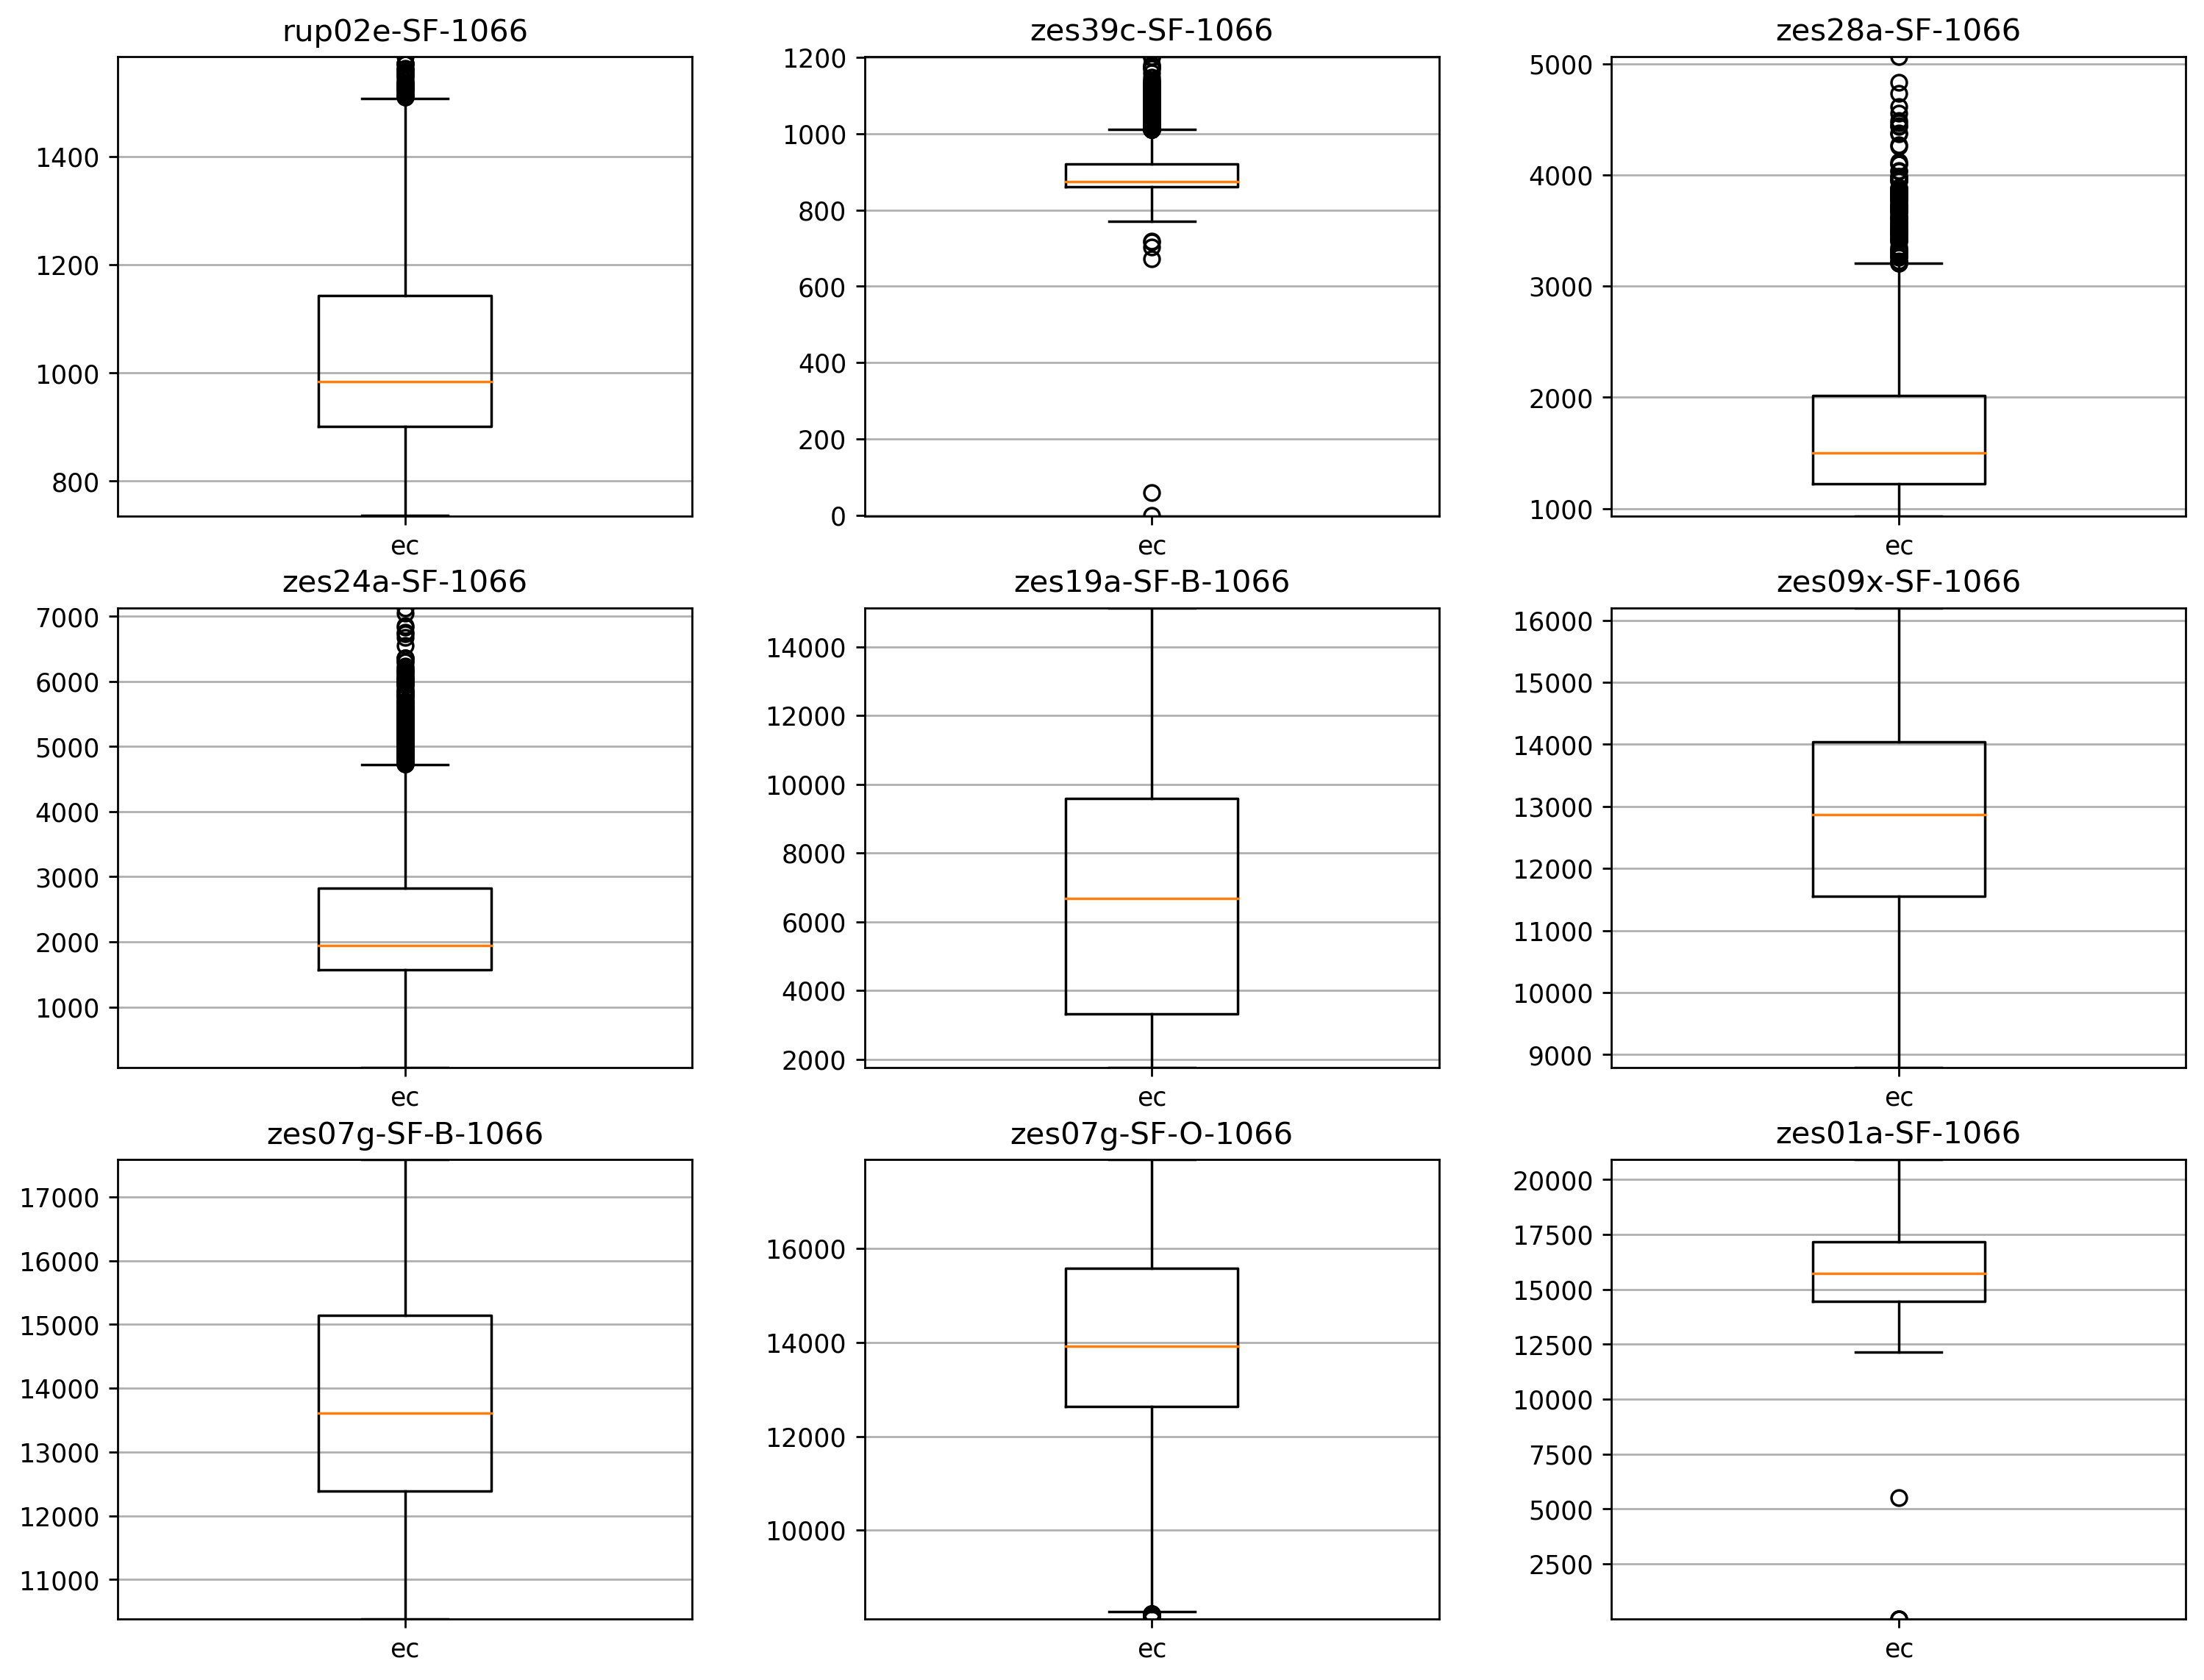

In [44]:
#lists to calculate statistics per station
maxl = []
minl = []
medl = []
meanl = []
stl = []
names = []
numbers = []
count = []
std = []
q25 = []
q75 = []
fig=plt.figure(figsize=(25, 10), dpi= 250)
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.5, top=0.9,wspace=0.3,hspace=0.2)
n = 3
k = 0
l = len(station_names)
filas = int(l/n) if int(l/n) % n == 0 else int(l/n)+1
m = 0
#march = big_df[big_df['ts'].dt.month==3]
march = big_df
while m < len(st):
  while m < k+n and m < len(st):
      try:
        #big_df.loc[st[m]]
        march.loc[st[m]]
      except:
        print(m)
        pass
      else:
        plt.subplot(filas,n,m+1)
        #data=big_df.loc[st[m]]['Value']
        data=march.loc[st[m]]['Value']
        plt.boxplot(data,widths=0.3)
        plt.ylim(data.min()-1,data.max()+1)
        plt.grid(axis='y')
        name = station_names[m]
        plt.title("{0}".format(name))
        plt.xticks([1],['ec'])
        maxl.append(data.max())
        minl.append(data.min())
        medl.append(data.quantile(0.5))
        meanl.append(data.mean())
        stl.append(m)
        names.append(name)
        numbers.append(st[m])
        std.append(data.std())
        count.append(data.count())
        q25.append(data.quantile(.25))
        q75.append(data.quantile(.75))
      m = m + 1
  k=k+n
  #plt.savef('Schelde_boxplots.png', dpi=250)
plt.show()


In [45]:
ec_stats = pd.DataFrame({"station": stl, "name": names, "Count": count,"media": meanl,"std": std,
                         "min":minl,"number": numbers,
                           "Q25": q25,"median": medl,
                         "Q75": q75,   "max":maxl})
#ec_stats.sort_values(by="median", ascending=False)
ec_stats=ec_stats.set_index('number')
ec_stats.to_csv('statsPerStation.csv')
ec_stats

,station,name,Count,media,std,min,Q25,median,Q75,max
number,,,,,,,,,,
255746,0,rup02e-SF-1066,2877,1032.872562,193.572684,736.78,900.8900,983.700,1144.00,1584.71
29666,1,zes39c-SF-1066,2881,900.588317,66.197414,0.00,860.5200,874.100,920.28,1200.97
29131,2,zes28a-SF-1066,1441,1763.520479,763.865616,935.04,1226.0600,1499.860,2017.72,5065.56
29221,3,zes24a-SF-1066,2881,2395.726827,1195.107736,72.48,1566.2000,1940.650,2828.31,7131.11
29472,4,zes19a-SF-B-1066,2881,6603.107740,3244.002918,1770.38,3316.3700,6684.050,9581.82,15129.36
268195,5,zes09x-SF-1066,2881,12761.963603,1644.528070,8797.00,11555.1800,12864.500,14044.24,16198.29
29315,6,zes07g-SF-B-1066,2881,13795.873249,1645.017658,10387.20,12388.0600,13613.610,15147.64,17590.14
29333,7,zes07g-SF-O-1066,2881,14068.217001,1806.039589,8117.48,12640.5100,13920.280,15569.23,17895.11
29732,8,zes01a-SF-1066,1436,15872.930251,2035.357484,2.81,14469.3025,15733.445,17181.65,20927.82


All boxplot together (to compare)

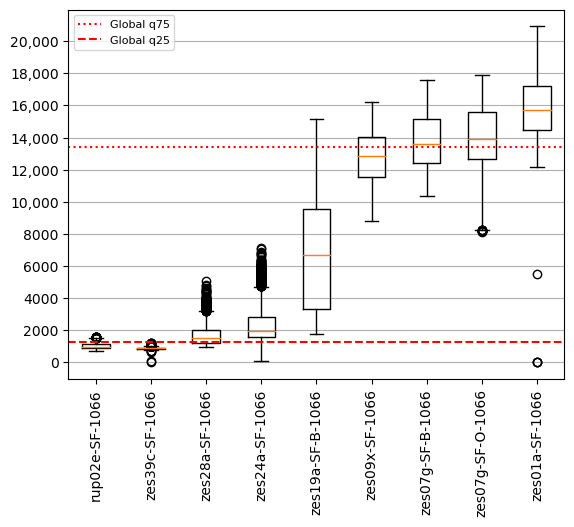

In [46]:
def myformat(x, pos):
    if x >= 10000:
        return "{:,}".format(x)
    else:
        return "{}".format(x)

lali=[big_df.loc[int(stations.loc[k]['number'])]['Value'] for k in station_names]
bp=plt.boxplot(lali)
plt.axhline(big_df['Value'].quantile(0.75), c='r', linestyle=":",label='Global q75')
plt.axhline(big_df['Value'].quantile(0.25), c='r', linestyle="--",label='Global q25')
#plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'])
plt.xticks(range(1,10),station_names, rotation=90)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(myformat)) # 2 decimal places
plt.yticks(range(int(big_df['Value'].min()),int(big_df['Value'].max())+1,2000))
plt.grid(axis='y')
plt.legend(prop={'size': 8})
plt.savefig('SchBoxplots.png',dpi=350, bbox_inches='tight')
plt.show()

Station Groups

In [47]:
station_groups = {"Group1":station_names[5:], "Group2":[station_names[4]],"Group3":station_names[:4]}
station_groups

{'Group1': ['zes09x-SF-1066',
  'zes07g-SF-B-1066',
  'zes07g-SF-O-1066',
  'zes01a-SF-1066'],
 'Group2': ['zes19a-SF-B-1066'],
 'Group3': ['rup02e-SF-1066',
  'zes39c-SF-1066',
  'zes28a-SF-1066',
  'zes24a-SF-1066']}

In [48]:
threshold_group={}
for g in station_groups.keys():
  thresholds =[big_df.loc[stations.loc[station_groups[g]]['number']]['Value'].min()-1,
               big_df.loc[stations.loc[station_groups[g]]['number']]['Value'].quantile(0.25),
               big_df.loc[stations.loc[station_groups[g]]['number']]['Value'].quantile(0.75),
               big_df.loc[stations.loc[station_groups[g]]['number']]['Value'].max()+1]
  for s in station_groups[g]:
    threshold_group[s]=thresholds
threshold_group

{'zes09x-SF-1066': [1.81, 12417.635, 15291.02, 20928.82],
 'zes07g-SF-B-1066': [1.81, 12417.635, 15291.02, 20928.82],
 'zes07g-SF-O-1066': [1.81, 12417.635, 15291.02, 20928.82],
 'zes01a-SF-1066': [1.81, 12417.635, 15291.02, 20928.82],
 'zes19a-SF-B-1066': [1769.38, 3316.37, 9581.82, 15130.36],
 'rup02e-SF-1066': [-1.0, 890.04, 1668.71, 7132.11],
 'zes39c-SF-1066': [-1.0, 890.04, 1668.71, 7132.11],
 'zes28a-SF-1066': [-1.0, 890.04, 1668.71, 7132.11],
 'zes24a-SF-1066': [-1.0, 890.04, 1668.71, 7132.11]}

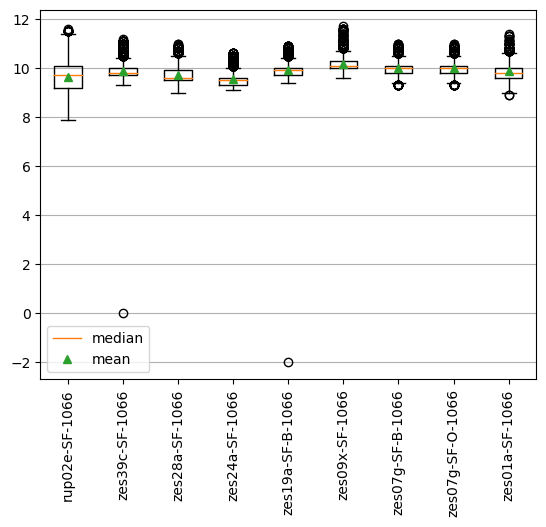

In [49]:
lali=[temp_df.loc[int(stations.loc[k]['number'])]['Value'] for k in station_names]
bp=plt.boxplot(lali, showmeans=True)
plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'])
plt.xticks(range(1,10),station_names, rotation=90)
#plt.yticks(range(int(temp_df['Value'].min()),int(big_df['Value'].max())+1,2000))
plt.grid(axis='y')
plt.savefig('SchBoxplotsTW.png',dpi=350, bbox_inches='tight')
plt.show()

DROP outliers

In [50]:
temp_df.loc[stations.loc['zes19a-SF-B-1066']['number']]['Value'].min()
temp_df[temp_df['Value']==-2]
temp_df=temp_df.reset_index()
temp_df=temp_df.set_index('index')
temp_df=temp_df.drop(12490)
temp_df=temp_df.reset_index()
temp_df=temp_df.set_index('Station')
temp_df.loc[stations.loc['zes19a-SF-B-1066']['number']]['Value'].min()


9.4

In [51]:
temp_df.loc[stations.loc['zes39c-SF-1066']['number']]['Value'].min()
temp_df[temp_df['Value']==0]
temp_df=temp_df.reset_index()
temp_df=temp_df.set_index('index')
temp_df=temp_df.drop(13686)
temp_df=temp_df.reset_index()
temp_df=temp_df.set_index('Station')
temp_df.loc[stations.loc['zes39c-SF-1066']['number']]['Value'].min()


9.3

In [52]:
temp_df.describe()

,index,Unnamed: 0,Value,NValue
count,23038.000000,23038.000000,23038.000000,23038.000000
mean,11519.363834,11519.363834,9.871456,0.507445
std,6651.489759,6651.489759,0.428847,0.279721
min,0.000000,0.000000,7.900000,0.000000
25%,5759.250000,5759.250000,9.600000,0.280000
50%,11518.500000,11518.500000,9.900000,0.440000
75%,17279.750000,17279.750000,10.100000,0.850000
max,23039.000000,23039.000000,11.700000,1.000000


# Plot for every station


In [53]:
q1=big_df['Value'].quantile(.25)
q3=big_df['Value'].quantile(.75)
q25=normalize(big_df['Value'].min(),big_df['Value'].max(),q1)
q75=normalize(big_df['Value'].min(),big_df['Value'].max(),q3)
print(q1,q25,q3,q75)

1241.9975 0.059346721254292134 13398.630000000001 0.6402305639096667


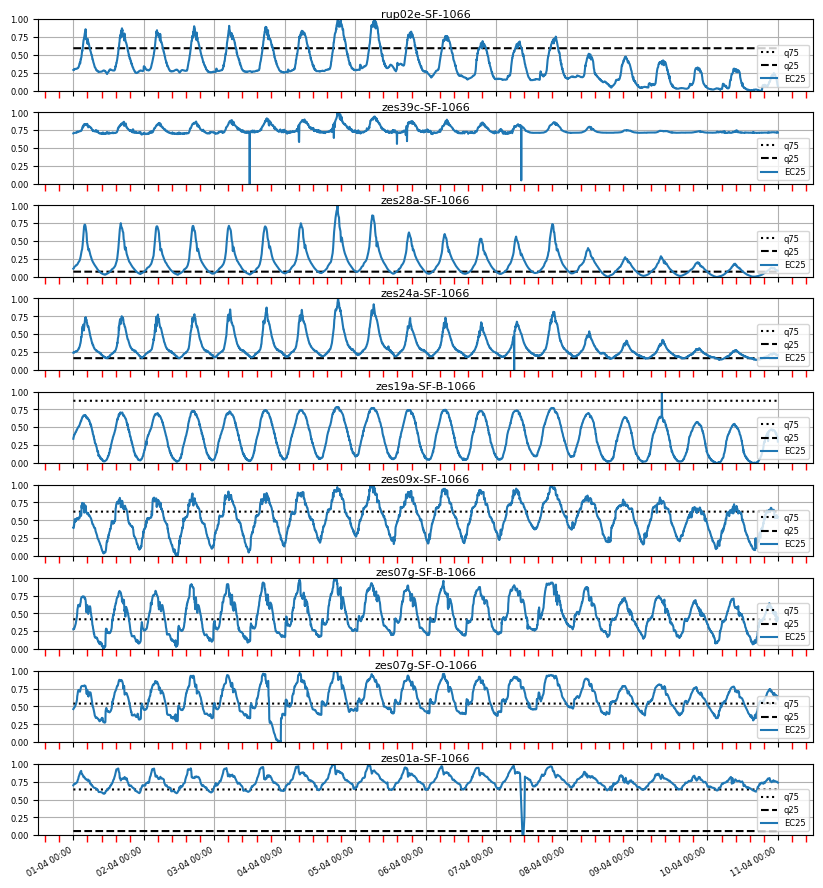

In [54]:
fig, axs = plt.subplots(len(station_names), 1, sharex=True, figsize=(10,12))
# Vertical space between axes
fig.subplots_adjust(hspace=0.3)

# Create a dataFrame with the local Max and the time
max_time=pd.DataFrame(columns=['Station','time','MaxValue','MaxValueNormalized'])
for i,sn in enumerate(station_names):
  #To filter the desired days and times
  filter = (big_df.loc[stations.loc[sn]['number']]['ts'].dt.day == 3)
  #&(big_df.loc[stations.loc[sn]['number']]['ts'].dt.hour < 12))
  data1 = big_df.loc[stations.loc[sn]['number']]#[filter]
  data = np.array(data1)
  time = data[:,4]
  max_time=pd.concat([max_time,pd.DataFrame({'Station':sn,
                                             'MaxValue':data1['Value'].max(),
                                             'MaxValueNormalized':data1['NValue'].max(),
                                             'time': data1[data1['Value']==data1['Value'].max()]['Timestamp']})])
  q25=normalize(data1['Value'].min(),data1['Value'].max(),q1)
  q75=normalize(data1['Value'].min(),data1['Value'].max(),q3)
  #print(data1['Value'].min(),data1['Value'].max(),q1)
  #print(q25,q75)
  axs[i].plot(time,[q75]*len(time), color='black', linestyle='dotted',label='q75')
  axs[i].plot(time,[q25]*len(time), color='black', linestyle='dashed',label='q25')
  axs[i].plot(time,data[:,-1], label='EC25')

  #axs[i].set_ylim(data1['Value'].min(),data1['Value'].max())
  axs[i].set_ylim(0,1)
  axs[i].set_title(sn, fontdict={'fontsize': 8}, pad=1)
  axs[i].tick_params(labelsize=6)
  axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))   #to get a tick every hour
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'), )     #optional formatting
  axs[i].xaxis.set_minor_locator(AutoMinorLocator())
  # customize the ticks - color, length and width
  axs[i].tick_params(which='minor', length=5, width=1,color='red')

  # auto-format
  fig.autofmt_xdate()

  axs[i].legend(loc=4, prop={'size': 6})
  axs[i].grid()
plt.savefig('NormalizedValue-TimeQ25Q75.png', dpi=500, bbox_inches='tight')
plt.show()

In [55]:
temp_df.head()

,index,Unnamed: 0,Timestamp,Value,ts,NValue
Station,,,,,,
29131,0,0,2022-04-01 00:00:00+00:00,11.0,2022-04-01 00:00:00+00:00,1.00
29131,1,1,2022-04-01 00:10:00+00:00,11.0,2022-04-01 00:10:00+00:00,1.00
29131,2,2,2022-04-01 00:20:00+00:00,10.9,2022-04-01 00:20:00+00:00,0.95
29131,3,3,2022-04-01 00:30:00+00:00,10.9,2022-04-01 00:30:00+00:00,0.95
29131,4,4,2022-04-01 00:40:00+00:00,10.9,2022-04-01 00:40:00+00:00,0.95


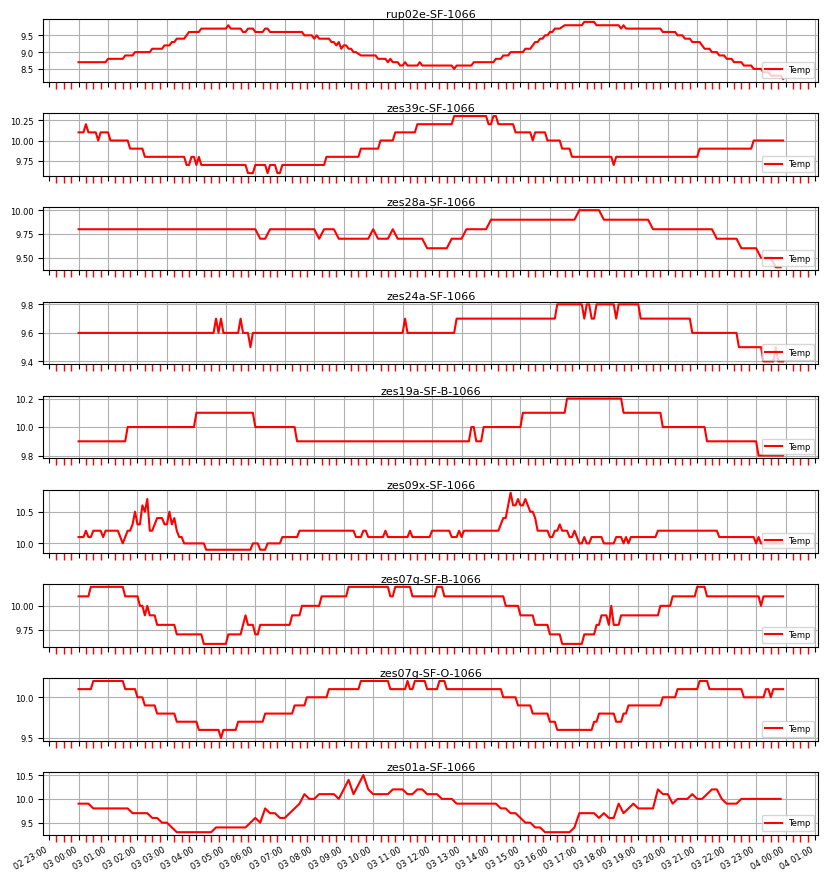

In [56]:
fig, axs = plt.subplots(len(station_names), 1, sharex=True, figsize=(10,12))
# Vertical space between axes
fig.subplots_adjust(hspace=0.5)

# Create a dataFrame with the local Max and the time
max_time_temp=pd.DataFrame(columns=['Station','time','MaxValue','MaxValueNormalized'])
for i,sn in enumerate(station_names):
  #To filter the desired days and times
  filter = (temp_df.loc[stations.loc[sn]['number']]['ts'].dt.day == 3)
  #& (temp_df.loc[stations.loc[sn]['number']]['ts'].dt.day < 10))
  data1 = temp_df.loc[stations.loc[sn]['number']][filter]
  data = np.array(data1)
  time = data[:,4]
  #max_time_temp=pd.concat([max_time_temp,pd.DataFrame({'Station':sn,
  #                                           'MaxValue':data1['Value'].max(),
  #                                           'MaxValueNormalized':data1['NValue'].max(),
  #                                           'time': data1[data1['Value']==data1['Value'].max()]['Timestamp']})])
  axs[i].plot(time,data[:,3], label='Temp', color='red')
  #axs[i].set_ylim(0, 1)
  axs[i].set_title(sn, fontdict={'fontsize': 8}, pad=1)
  axs[i].tick_params(labelsize=6)
  axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=1))   #to get a tick every hour
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'), )     #optional formatting
  axs[i].xaxis.set_minor_locator(AutoMinorLocator())
  # customize the ticks - color, length and width
  axs[i].tick_params(which='minor', length=5, width=1,color='red')

  # auto-format
  fig.autofmt_xdate()

  axs[i].legend(loc=4, prop={'size': 6})
  axs[i].grid()
#plt.savefig('NormalizedDay3-12:00-23:59.png', dpi=350)
plt.show()

#EC and Temperature

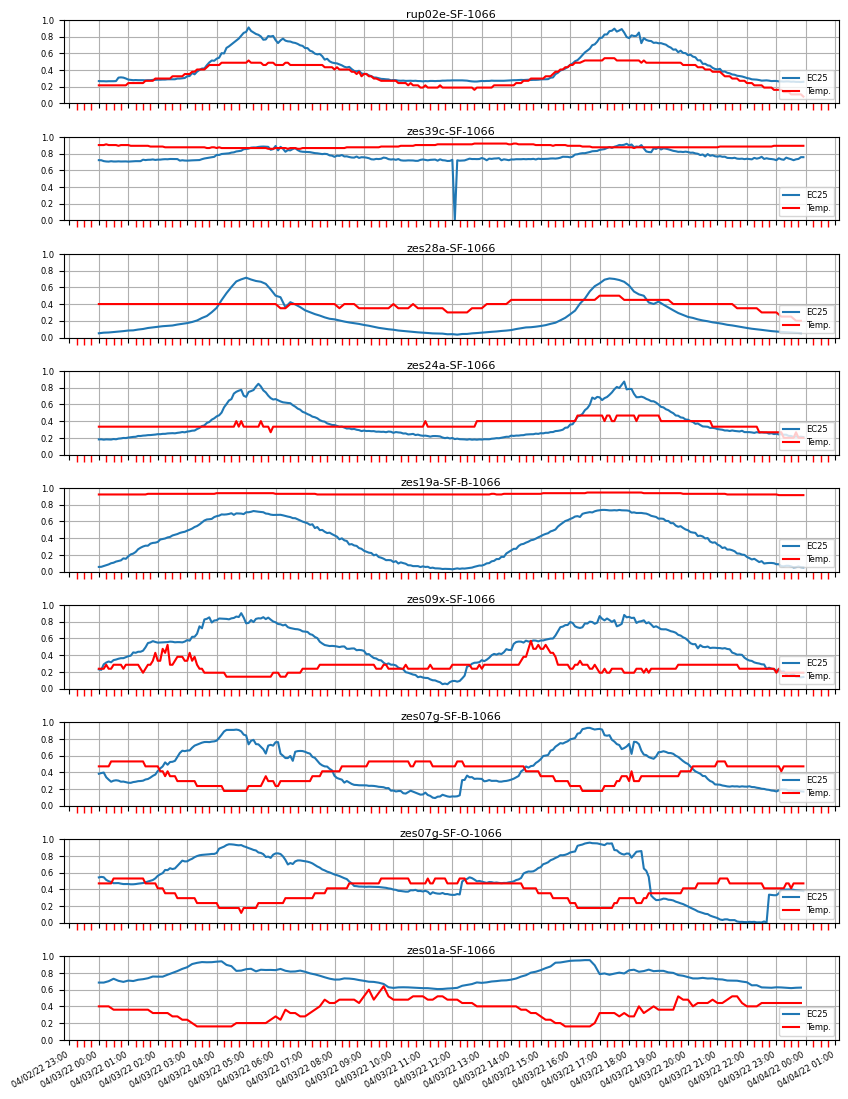

In [57]:
fig, axs = plt.subplots(len(station_names), 1, sharex=True, figsize=(10,15))
# Vertical space between axes
fig.subplots_adjust(hspace=0.4)

# Create a dataFrame with the local Max and the time
max_time=pd.DataFrame(columns=['Station','time','MaxValue','MaxValueNormalized'])
for i,sn in enumerate(station_names):
  st = stations.loc[sn]['number']
  #To filter the desired days and times
  filter = (big_df.loc[st]['ts'].dt.day == 3)
  #&(big_df.loc[st]['ts'].dt.hour < 12))
  filtert = (temp_df.loc[st]['ts'].dt.day == 3)
  #&(temp_df.loc[st]['ts'].dt.hour < 12))

  data1 = big_df.loc[st][filter]
  data = np.array(data1)
  time = data[:,4]
  max_time=pd.concat([max_time,pd.DataFrame({'Station':sn,
                                             'MaxValue':data1['Value'].max(),
                                             'MaxValueNormalized':data1['NValue'].max(),
                                             'time': data1[data1['Value']==data1['Value'].max()]['Timestamp']})])
  data1t = temp_df.loc[st][filtert]
  datat = np.array(data1t)
  timet = datat[:,4]

  axs[i].plot(time,data[:,-1], label='EC25')
  axs[i].plot(timet,datat[:,-1], label='Temp.', color='red')
  axs[i].set_ylim(0, 1)
  axs[i].tick_params(labelsize=6)
  axs[i].set_title(sn, fontdict={'fontsize': 8}, pad=1)
  axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=1))   #to get a tick every hour
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'), )     #optional formatting
  axs[i].xaxis.set_minor_locator(AutoMinorLocator())
  # customize the ticks - color, length and width
  axs[i].tick_params(which='minor', length=5, width=1,color='red')

  # auto-format
  fig.autofmt_xdate()

  axs[i].legend(loc=4, prop={'size': 6})
  axs[i].grid()
plt.savefig('NormalizedDay3 TW-EC.png', dpi=350, bbox_inches='tight')
plt.show()

Compute the Pearson correlation factor.

In [58]:
for sn in station_names:
  filter = (big_df.loc[stations.loc[sn]['number']]['ts'].dt.day == 3)
  filtert = (temp_df.loc[stations.loc[sn]['number']]['ts'].dt.day == 3)

  data1 = big_df.loc[stations.loc[sn]['number']][filter]['Value']
  data2 = temp_df.loc[stations.loc[sn]['number']][filtert]['Value']
  print(sn +' :' , data1.corr(data2))

rup02e-SF-1066 : 0.8977606279970926
zes39c-SF-1066 : 4.233236179617999e-17
zes28a-SF-1066 : 0.5356270352858975
zes24a-SF-1066 : 0.4382368531170234
zes19a-SF-B-1066 : 0.8634938638560201
zes09x-SF-1066 : -0.16504846968303225
zes07g-SF-B-1066 : -0.9476204279472054
zes07g-SF-O-1066 : -0.7930104312209892
zes01a-SF-1066 : -0.8703625570896655


In [59]:
fil = stations.loc['zes09x-SF-1066']['number']
filter = (big_df.loc[fil]['ts'].dt.day == 3)
filtert = (temp_df.loc[fil]['ts'].dt.day == 3)

data1 = big_df.loc[fil][filter]['Value']
data2 = temp_df.loc[fil][filtert]['Value']
print('zes09x-SF-1066' +' :' , data1.corr(data2))

zes09x-SF-1066 : -0.16504846968303225


#Plot accross time for all the daset

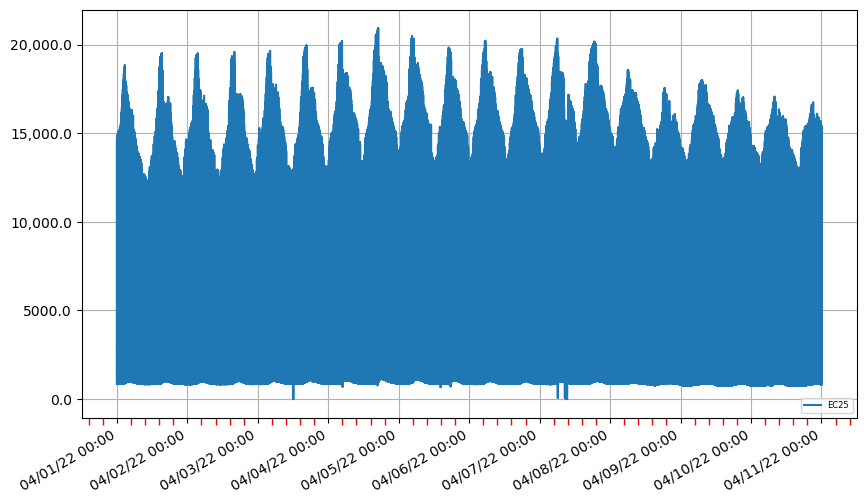

In [60]:
fig, axs = plt.subplots(figsize=(10,6))
# Vertical space between axes

# Create a dataFrame with the local Max and the time
#To filter the desired days and times
#  filter = (big_df.loc[stations.loc[sn]['number']]['ts'].dt.day == 3)
  #&(big_df.loc[stations.loc[sn]['number']]['ts'].dt.hour < 12))
  #data1 = big_df.loc[stations.loc[sn]['number']][filter]
data = big_df[['Value','ts']]
data = data.sort_values(by='ts')
time = data['ts']
axs.plot(time,data['Value'], label='EC25')
#axs[i].set_ylim(0, 1)
#axs[i].set_title(sn, fontdict={'fontsize': 8}, pad=1)
#axs[i].tick_params(labelsize=6)
axs.xaxis.set_major_locator(mdates.DayLocator(interval=1))   #to get a tick every hour
axs.xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'), )     #optional formatting
axs.xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(myformat))
# customize the ticks - color, length and width
axs.tick_params(which='minor', length=5, width=1,color='red')

# auto-format
fig.autofmt_xdate()

axs.legend(loc=4, prop={'size': 6})
axs.grid()
plt.savefig('GlobalDataOverTime.png', dpi=350, bbox_inches='tight' )
plt.show()

In [61]:
big_df[['Value','ts']]

,Value,ts
Station,,
29131,1412.81,2022-04-01 00:00:00+00:00
29131,1434.60,2022-04-01 00:10:00+00:00
29131,1512.09,2022-04-01 00:20:00+00:00
29131,1535.31,2022-04-01 00:30:00+00:00
29131,1557.16,2022-04-01 00:40:00+00:00
...,...,...
268195,12993.36,2022-04-10 23:40:00+00:00
268195,12859.12,2022-04-10 23:45:00+00:00
268195,12724.88,2022-04-10 23:50:00+00:00


Continuous and discrete

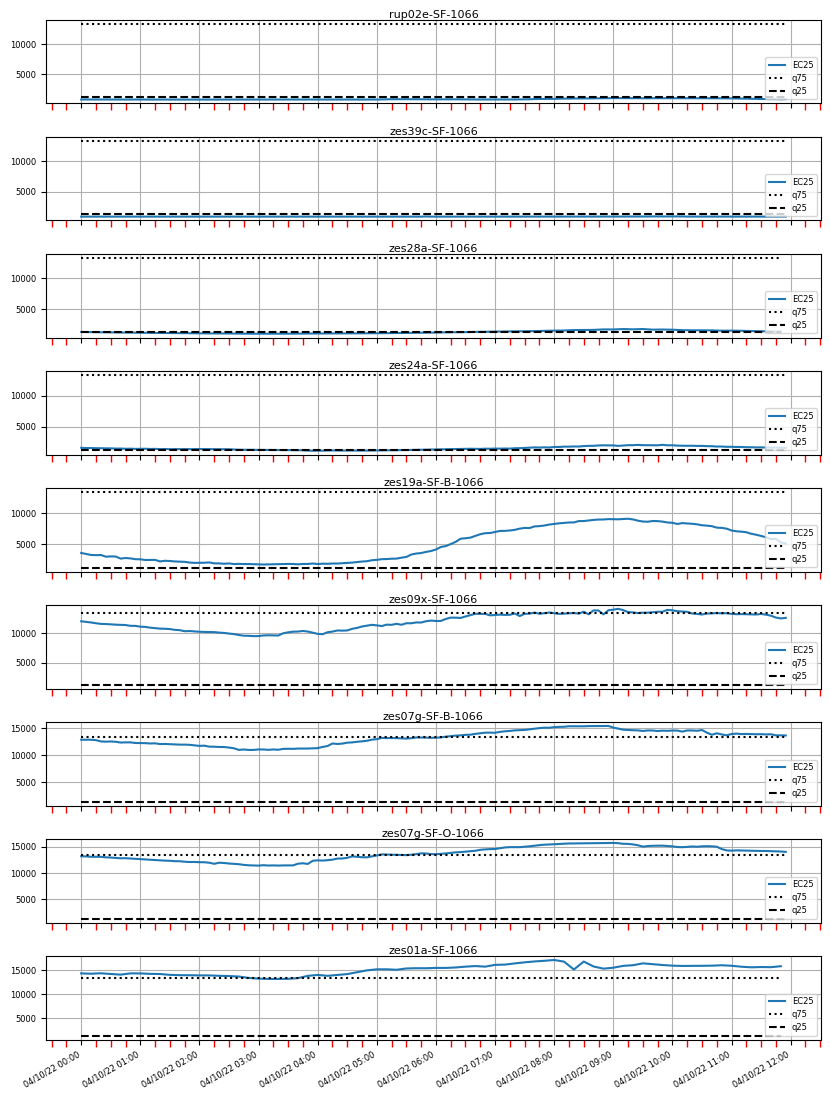

In [62]:
fig, axs = plt.subplots(len(station_names), 1, sharex=True, figsize=(10,15))
# Vertical space between axes
fig.subplots_adjust(hspace=0.4)

# Create a dataFrame with the local Max and the time
max_time=pd.DataFrame(columns=['Station','time','MaxValue','MaxValueNormalized'])
for i,sn in enumerate(station_names):
  st = stations.loc[sn]['number']
  #To filter the desired days and times
  filter = ((big_df.loc[st]['ts'].dt.day == 10) &(big_df.loc[st]['ts'].dt.hour < 12))

  data1 = big_df.loc[st][filter]
  data = np.array(data1)
  time = data[:,4]

  axs[i].plot(time,data[:,3], label='EC25')
  axs[i].plot(time,[q3]*len(time), color='black', linestyle='dotted',label='q75')
  axs[i].plot(time,[q1]*len(time), color='black', linestyle='dashed',label='q25')
  #axs[i].set_ylim(0, 1)
  axs[i].tick_params(labelsize=6)
  axs[i].set_title(sn, fontdict={'fontsize': 8}, pad=1)
  axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=1))   #to get a tick every hour
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'), )     #optional formatting
  axs[i].xaxis.set_minor_locator(AutoMinorLocator())
  # customize the ticks - color, length and width
  axs[i].tick_params(which='minor', length=5, width=1,color='red')

  # auto-format
  fig.autofmt_xdate()

  axs[i].legend(loc=4, prop={'size': 6})
  axs[i].grid()
#plt.savefig('NormalizedDay3 TW-EC.png', dpi=350, bbox_inches='tight')
plt.show()

In [64]:
def plot_station(big_df, sn, day, time, i, q1,q3,axs ):
  st = stations.loc[sn]['number']
  #To filter the desired days and times
  filter = ((big_df.loc[st]['ts'].dt.day == 10) &(big_df.loc[st]['ts'].dt.hour < 12))

  data1 = big_df.loc[st][filter]
  data = np.array(data1)
  time = data[:,4]

  axs.plot(time,data[:,3], label='EC25')
  axs.plot(time,[q3]*len(time), color='black', linestyle='dotted',label='q75')
  #axs.plot(time,[q1]*len(time), color='black', linestyle='dashed',label='q25')
  #axs[i].set_ylim(0, 1)
  axs.tick_params(labelsize=6)
  axs.set_title(sn, fontdict={'fontsize': 8}, pad=1)
  axs.xaxis.set_major_locator(mdates.HourLocator(interval=1))   #to get a tick every hour
  axs.xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'), )     #optional formatting
  axs.xaxis.set_minor_locator(AutoMinorLocator())
  # customize the ticks - color, length and width
  axs.tick_params(which='minor', length=5, width=1,color='red')

  # auto-format
  fig.autofmt_xdate()

  axs.legend(loc=4, prop={'size': 6})
  axs.grid()